## Prediction using ARIMA

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [75]:
df = pd.read_csv("../Dataset/demo_inventory_demand_trends.csv")

In [78]:
df['date'] = pd.to_datetime(df['date'])

In [79]:
df = df.sort_values(by='date', ascending=True)

In [80]:
# Assume df['date'] and df['demand'] exist and are sorted
train = df.iloc[:-90].copy()
test = df.iloc[-90:].copy()

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (5681, 3)
Test size: (90, 3)


### Moving Average Only - 7, 14 and 30 Days

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Reshape needed for scaler
train['demand_scaled'] = scaler.fit_transform(train['demand'].values.reshape(-1,1))
test['demand_scaled'] = scaler.transform(test['demand'].values.reshape(-1,1))

# Check
train.head()
test.head()



,date,inventory,demand,demand_scaled
5681,2025-07-22,255,161,0.715556
5682,2025-07-23,262,189,0.840000
5683,2025-07-24,270,120,0.533333
5684,2025-07-25,260,129,0.573333
5685,2025-07-26,268,138,0.613333


In [83]:
def moving_average_forecast(series, window):
    """Compute moving average forecast for given window size."""
    forecast = series.rolling(window=window).mean()
    # Forecast the next 90 days with the last known moving average
    last_avg = forecast.iloc[-1]
    future_forecast = np.repeat(last_avg, len(test))
    return future_forecast


In [84]:
# Forecast using different windows
forecast_7 = moving_average_forecast(train['demand_scaled'], 7)
forecast_14 = moving_average_forecast(train['demand_scaled'], 14)
forecast_30 = moving_average_forecast(train['demand_scaled'], 30)

# Compare to actual test data
mae_7 = mean_absolute_error(test['demand_scaled'], forecast_7)
mae_14 = mean_absolute_error(test['demand_scaled'], forecast_14)
mae_30 = mean_absolute_error(test['demand_scaled'], forecast_30)

rmse_7 = np.sqrt(mean_squared_error(test['demand_scaled'], forecast_7))
rmse_14 = np.sqrt(mean_squared_error(test['demand_scaled'], forecast_14))
rmse_30 = np.sqrt(mean_squared_error(test['demand_scaled'], forecast_30))

print(f"7-Day MA → MAE: {mae_7:.2f}, RMSE: {rmse_7:.2f}")
print(f"14-Day MA → MAE: {mae_14:.2f}, RMSE: {rmse_14:.2f}")
print(f"30-Day MA → MAE: {mae_30:.2f}, RMSE: {rmse_30:.2f}")

7-Day MA → MAE: 0.10, RMSE: 0.13
14-Day MA → MAE: 0.11, RMSE: 0.13
30-Day MA → MAE: 0.12, RMSE: 0.15


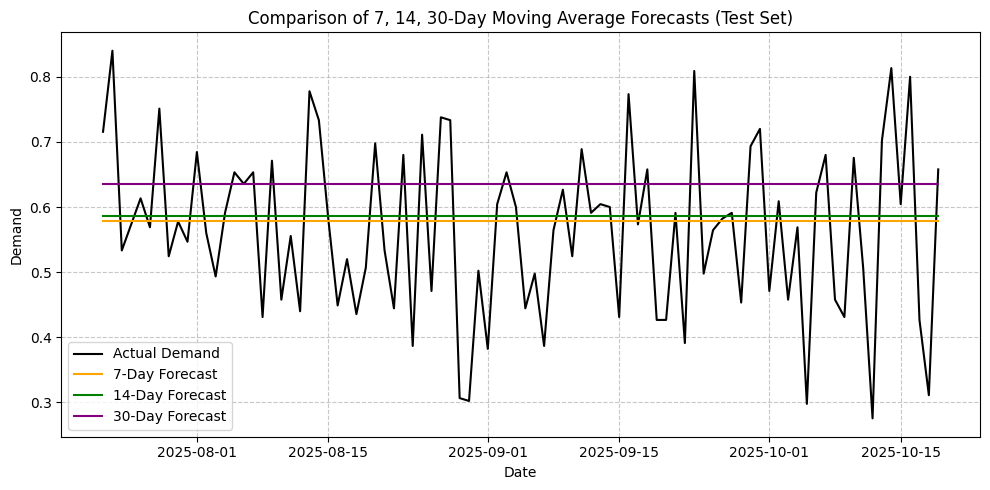

In [85]:
plt.figure(figsize=(10,5))
plt.plot(test['date'], test['demand_scaled'], label='Actual Demand', color='black')
plt.plot(test['date'], forecast_7, label='7-Day Forecast', color='orange')
plt.plot(test['date'], forecast_14, label='14-Day Forecast', color='green')
plt.plot(test['date'], forecast_30, label='30-Day Forecast', color='purple')

plt.title('Comparison of 7, 14, 30-Day Moving Average Forecasts (Test Set)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [86]:
errors = {
    '7-Day MA': rmse_7,
    '14-Day MA': rmse_14,
    '30-Day MA': rmse_30
}

best_model = min(errors, key=errors.get)
print(f"Best performing model: {best_model}")
print(f"RMSE: {errors[best_model]:.2f}")

Best performing model: 7-Day MA
RMSE: 0.13


In [87]:
# Compute average daily demand
avg_demand = train['demand_scaled'].mean()

# Given RMSE (from best model)
best_rmse = errors[best_model]  # replace with your actual best RMSE variable if you stored it

# Calculate relative RMSE percentage
relative_rmse = (best_rmse / avg_demand) * 100

print(f"Average Demand: {avg_demand:.2f}")
print(f"RMSE: {best_rmse:.2f}")
print(f"Relative RMSE: {relative_rmse:.2f}% of average demand")


Average Demand: 0.44
RMSE: 0.13
Relative RMSE: 29.45% of average demand


### ARIMA - 7, 14 and 30 Days

In [88]:
def fit_arima_and_forecast(train_series, test_series, order):
    """Fit ARIMA model with given order and forecast for test period."""
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    
    rmse = np.sqrt(mean_squared_error(test_series, forecast))
    mae = mean_absolute_error(test_series, forecast)
    
    return forecast, rmse, mae


In [89]:
# Model 1: ARIMA(7,1,0) → similar to 7-day window
forecast_7, rmse_7, mae_7 = fit_arima_and_forecast(train['demand'], test['demand'], order=(7,1,0))

# Model 2: ARIMA(14,1,0) → similar to 14-day window
forecast_14, rmse_14, mae_14 = fit_arima_and_forecast(train['demand'], test['demand'], order=(14,1,0))

# Model 3: ARIMA(30,1,0) → similar to 30-day window
forecast_30, rmse_30, mae_30 = fit_arima_and_forecast(train['demand'], test['demand'], order=(30,1,0))


In [90]:
errors = {
    'ARIMA(7,1,0)': rmse_7,
    'ARIMA(14,1,0)': rmse_14,
    'ARIMA(30,1,0)': rmse_30
}

best_model = min(errors, key=errors.get)
print("Model RMSEs:")
for k, v in errors.items():
    print(f"{k}: {v:.2f}")

print(f"\nBest performing ARIMA model: {best_model}")
print(f"RMSE: {errors[best_model]:.2f}")


Model RMSEs:
ARIMA(7,1,0): 28.63
ARIMA(14,1,0): 28.38
ARIMA(30,1,0): 27.92

Best performing ARIMA model: ARIMA(30,1,0)
RMSE: 27.92


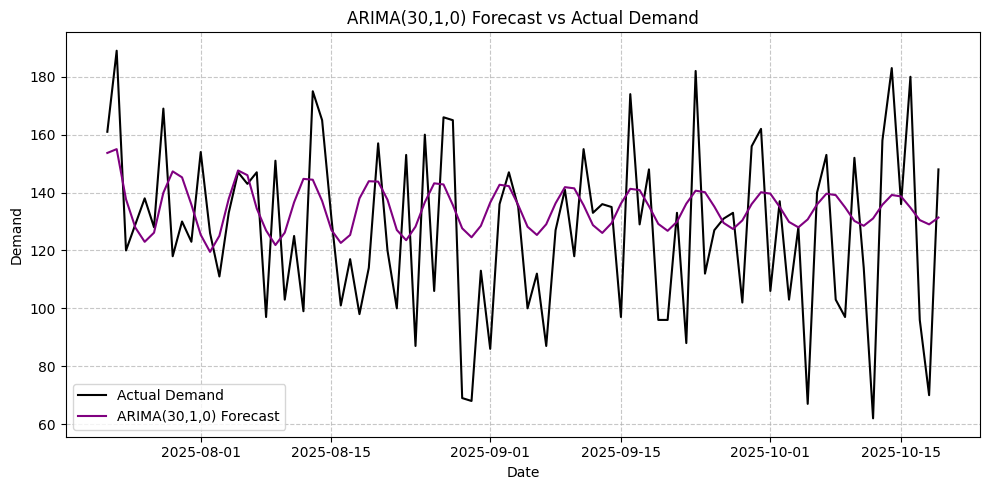

In [91]:
plt.figure(figsize=(10,5))
plt.plot(test['date'], test['demand'], label='Actual Demand', color='black')

if best_model == 'ARIMA(7,1,0)':
    plt.plot(test['date'], forecast_7, label='ARIMA(7,1,0) Forecast', color='orange')
elif best_model == 'ARIMA(14,1,0)':
    plt.plot(test['date'], forecast_14, label='ARIMA(14,1,0) Forecast', color='green')
else:
    plt.plot(test['date'], forecast_30, label='ARIMA(30,1,0) Forecast', color='purple')

plt.title(f"{best_model} Forecast vs Actual Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [92]:
# Compute average daily demand
avg_demand = df['demand'].mean()

# Given RMSE (from best model)
best_rmse = errors[best_model]  # replace with your actual best RMSE variable if you stored it

# Calculate relative RMSE percentage
relative_rmse = (best_rmse / avg_demand) * 100

print(f"Average Demand: {avg_demand:.2f}")
print(f"RMSE: {best_rmse:.2f}")
print(f"Relative RMSE: {relative_rmse:.2f}% of average demand")


Average Demand: 99.48
RMSE: 27.92
Relative RMSE: 28.07% of average demand


## SARIMA

In [93]:
# SARIMA simulating 7-day pattern
sarima_7 = SARIMAX(
    train['demand'],
    order=(2,1,2),             # non-seasonal ARIMA terms
    seasonal_order=(1,1,1,7),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit_7 = sarima_7.fit(disp=False)
forecast_7 = sarima_fit_7.forecast(steps=len(test))
rmse_7 = np.sqrt(mean_squared_error(test['demand'], forecast_7))
print(f"SARIMA 7-Day Analog RMSE: {rmse_7:.2f}")


c:\Users\Administrator\Desktop\Hackathon\OneAIHackathon2025\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA 7-Day Analog RMSE: 25.85


In [94]:
# SARIMA simulating 14-day pattern
sarima_14 = SARIMAX(
    train['demand'],
    order=(2,1,2),
    seasonal_order=(1,1,1,14),  # 14-day seasonal cycle
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit_14 = sarima_14.fit(disp=False)
forecast_14 = sarima_fit_14.forecast(steps=len(test))
rmse_14 = np.sqrt(mean_squared_error(test['demand'], forecast_14))
print(f"SARIMA 14-Day Analog RMSE: {rmse_14:.2f}")

c:\Users\Administrator\Desktop\Hackathon\OneAIHackathon2025\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA 14-Day Analog RMSE: 25.90


In [95]:
# SARIMA simulating 30-day pattern
sarima_30 = SARIMAX(
    train['demand'],
    order=(2,1,2),
    seasonal_order=(1,1,1,30),  # 30-day seasonal cycle
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit_30 = sarima_30.fit(disp=False)
forecast_30 = sarima_fit_30.forecast(steps=len(test))
rmse_30 = np.sqrt(mean_squared_error(test['demand'], forecast_30))
print(f"SARIMA 30-Day Analog RMSE: {rmse_30:.2f}")


c:\Users\Administrator\Desktop\Hackathon\OneAIHackathon2025\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA 30-Day Analog RMSE: 29.79


In [45]:
# SARIMA simulating 90-day pattern
sarima_90 = SARIMAX(
    train['demand'],
    order=(2,1,2),
    seasonal_order=(1,1,1,90),  # 90-day seasonal cycle
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit_90 = sarima_90.fit(disp=False)
forecast_90 = sarima_fit_90.forecast(steps=len(test))
rmse_90 = np.sqrt(mean_squared_error(test['demand'], forecast_90))
print(f"SARIMA 90-Day Analog RMSE: {rmse_90:.2f}")


c:\Users\Administrator\Desktop\Hackathon\OneAIHackathon2025\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA 90-Day Analog RMSE: 119.45


In [96]:
errors_sarima = {
    'SARIMA 7-Day': rmse_7,
    'SARIMA 14-Day': rmse_14,
    'SARIMA 30-Day': rmse_30,
    # 'SARIMA 90-Day': rmse_90
}

best_sarima = min(errors_sarima, key=errors_sarima.get)
print("SARIMA Model RMSEs:")
for k, v in errors_sarima.items():
    print(f"{k}: {v:.2f}")

print(f"\nBest SARIMA model: {best_sarima}")


SARIMA Model RMSEs:
SARIMA 7-Day: 25.85
SARIMA 14-Day: 25.90
SARIMA 30-Day: 29.79

Best SARIMA model: SARIMA 7-Day


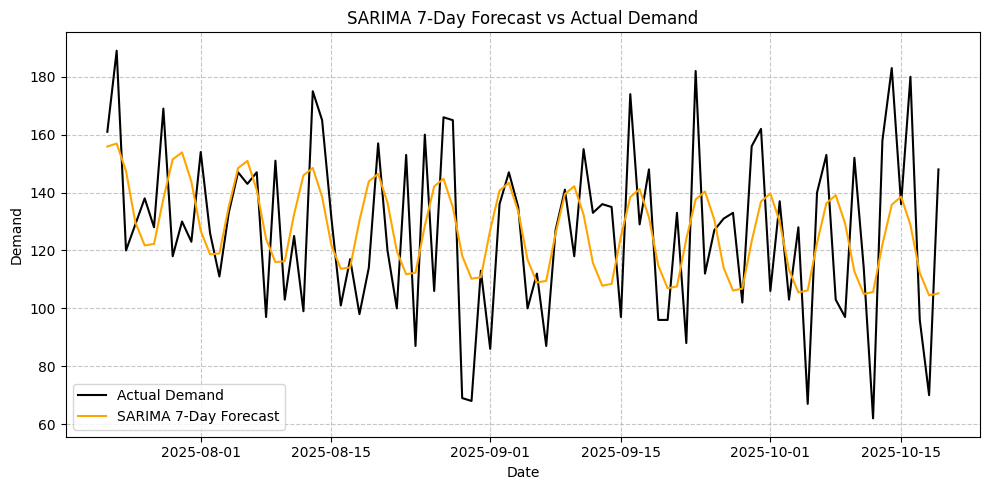

In [97]:
plt.figure(figsize=(10,5))
plt.plot(test['date'], test['demand'], label='Actual Demand', color='black')

if best_sarima == 'SARIMA 7-Day':
    plt.plot(test['date'], forecast_7, label='SARIMA 7-Day Forecast', color='orange')
elif best_sarima == 'SARIMA 14-Day':
    plt.plot(test['date'], forecast_14, label='SARIMA 14-Day Forecast', color='green')
else:
    plt.plot(test['date'], forecast_30, label='SARIMA 30-Day Forecast', color='purple')

plt.title(f"{best_sarima} Forecast vs Actual Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [98]:
# Average daily demand from the dataset
avg_demand = df['demand'].mean()
print(f"Average Daily Demand: {avg_demand:.2f}")

# Best SARIMA RMSE
best_rmse = errors_sarima[best_sarima]

# Relative RMSE (% of average demand)
relative_rmse = (best_rmse / avg_demand) * 100
print(f"Best SARIMA model: {best_sarima}")
print(f"RMSE: {best_rmse:.2f}")
print(f"Relative RMSE: {relative_rmse:.2f}% of average demand")


Average Daily Demand: 99.48
Best SARIMA model: SARIMA 7-Day
RMSE: 25.85
Relative RMSE: 25.99% of average demand


## Saving the best model

In [100]:
sarima_fit_7.save('sarima_7_model.pkl')

## Using model to predict next 90days

In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from datetime import timedelta

# 1. Load the saved SARIMA model
loaded_model = SARIMAXResults.load('sarima_7_model.pkl')

# 2. Forecast the next 90 days
forecast_steps = 90
forecast_values = loaded_model.forecast(steps=forecast_steps)

# 3. Create future dates starting after the last date in your data
# Replace 'last_date' with your last observed date, e.g., '2025-10-19'
last_date = pd.to_datetime('2025-10-19')
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps)

# 4. Create a DataFrame with dates and forecast
forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_demand': forecast_values
})

# 5. Save to CSV
forecast_df.to_csv('forecast_90_days.csv', index=False)

print(forecast_df.head())
print("Forecast CSV saved as 'forecast_90_days.csv'")

           date  predicted_demand
5681 2025-10-20        155.903749
5682 2025-10-21        156.934182
5683 2025-10-22        147.459273
5684 2025-10-23        129.694022
5685 2025-10-24        121.737418
Forecast CSV saved as 'forecast_90_days.csv'


In [107]:
forecast_df.to_csv('forecast_90_days.csv', index=False)